In [166]:
import time
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2017) # set random seed value to get reproducible results
from copy import deepcopy
from IPython.display import display_html
from datetime import datetime

In [167]:
# helper functions for displaying table data
# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [168]:
# store start time to get execution time of entire script
start_time = time.time()

### Load Data

In [169]:
grouping = 'stimulants'
#grouping = 'opioids'

df = pd.read_csv(grouping + '.csv', index_col=[0])
print(df.shape)
df.head()

(3328, 35)


,engage30,init,female_cd,unemplmt_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,und15_cd,CWSg_0_cd,srprobg_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,SFSg_0_cd,B2a_0g,Raceg4_cd_gr_1,Raceg4_cd_gr_2,Raceg4_cd_gr_3,Raceg4_cd_gr_4,pop_deng,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,0,0,0,0,1,0,2,1,0,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,0,1,0,0,0,2.0,1.0,1.0,1.0
1,0,0,0,0,1,0,1,2,2,1,0,1,1,1,1,1,2,0,2,1,1,1,1,2,0,0,0,1,0,0,0,2.0,1.0,1.0,1.0
2,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,2,1,2,0,1,2,1,0,0,1,0,0,0,2.0,0.0,1.0,1.0
3,1,0,0,0,0,1,0,2,2,1,0,1,1,1,0,2,2,0,2,2,2,0,0,2,1,0,0,1,0,0,0,2.0,1.0,1.0,2.0
4,0,0,0,0,0,1,1,1,2,1,0,1,1,1,1,2,2,0,2,2,2,0,1,2,1,0,0,1,0,0,0,2.0,0.0,1.0,1.0


In [170]:
df = df.astype({'pop_deng': 'int64', '%_unemployedg': 'int64', '%_public_assistanceg': 'int64', '%_povertyg': 'int64'})

In [171]:
df.drop(columns=['epsg_0_cd'], inplace=True) # since dssg and epsg are correlated

In [172]:
df.head()

,engage30,init,female_cd,unemplmt_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,und15_cd,CWSg_0_cd,srprobg_cd,dldiag_cd,dssg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,SFSg_0_cd,B2a_0g,Raceg4_cd_gr_1,Raceg4_cd_gr_2,Raceg4_cd_gr_3,Raceg4_cd_gr_4,pop_deng,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,0,0,0,0,1,0,2,1,0,1,1,2,2,2,0,2,2,2,1,1,2,1,0,0,1,0,0,0,2,1,1,1
1,0,0,0,0,1,0,1,2,2,1,0,1,1,1,1,2,0,2,1,1,1,1,2,0,0,0,1,0,0,0,2,1,1,1
2,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,0,2,1,2,0,1,2,1,0,0,1,0,0,0,2,0,1,1
3,1,0,0,0,0,1,0,2,2,1,0,1,1,1,2,2,0,2,2,2,0,0,2,1,0,0,1,0,0,0,2,1,1,2
4,0,0,0,0,0,1,1,1,2,1,0,1,1,1,2,2,0,2,2,2,0,1,2,1,0,0,1,0,0,0,2,0,1,1


### Outcome Distribution

In [173]:
#df['init'].value_counts() # 1 represents a patient who did not initiate

In [174]:
df['engage30'].value_counts() # 1 represents a patient who did not engage

0    2178
1    1150
Name: engage30, dtype: int64

### Modelling

In [175]:
def run_model(model, X_train, X_test, y_train, y_test, outcome):
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape) 
    
    # combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[outcome] == 0]
    positive = train_data[train_data[outcome] == 1]
    
    # upsample minority
    pos_upsampled = resample(positive, 
                               replace=True, # sample with replacement
                               n_samples=len(negative)) # match number in minority class
    
    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    X_train = upsampled.drop(columns=[outcome])
    y_train = upsampled[outcome]
    
    print("Sampled training set outcome counts:\n", y_train.value_counts().to_frame())
        
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5, scoring='roc_auc')
    top_model_ind = list(res['test_score']).index(max(list(res['test_score']))) # get index of top performing model
    top_model = res['estimator'][top_model_ind] # get top performing model
    
    y_pred = top_model.predict_proba(X_test)[:,1] 
    
    y_pred_bin = deepcopy(y_pred)
    y_pred_bin[y_pred_bin < 0.25] = 0
    y_pred_bin[y_pred_bin >= 0.25] = 1

    accuracy = metrics.accuracy_score(y_test, y_pred_bin)
    f1 = metrics.f1_score(y_test, y_pred_bin)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred_bin)
    recall = metrics.recall_score(y_test, y_pred_bin)
    
    print("Test set outcome counts:\n", y_test.value_counts().to_frame())
    print("Test set outcome percentages:\n", y_test.value_counts(normalize=True).to_frame())

    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC:", auc)
    
    result = permutation_importance(top_model, X_test, y_test, scoring='roc_auc')
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
    
    try:
        # random forest
        feature_importance = top_model.feature_importances_ 
        label = "RF-" + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(top_model.coef_[0]) # hazard ratios
        label = "LR-" + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
        
    features = X_train.columns
    #feature_importance_df = pd.DataFrame({"feature": features, label: result['importances_mean']}) # PFI
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df, [label, y_test.value_counts(normalize=True)[1], y_test.value_counts(normalize=True)[0], X_train.shape[0], accuracy, f1, precision, recall, auc]

In [176]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all(): # if non-binary
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    print('Logistic Regression Features:', result.columns)
    return result

In [177]:
data = df.drop(columns=['init', 'engage30'])
engage30 = df['engage30']
#init = df['init']

engage30_X_train, engage30_X_test, engage30_y_train, engage30_y_test = train_test_split(data, engage30, test_size=0.25, random_state=2017)
#init_X_train, init_X_test, init_y_train, init_y_test = train_test_split(data, init, test_size=0.25)
performance = []

print('Features:', data.columns)

Features: Index(['female_cd', 'unemplmt_cd', 'prsatx_cd', 'TRIg_0_cd', 'TMIg_0_cd',
       'SESg_0_cd', 'gvsg_cd', 'und15_cd', 'CWSg_0_cd', 'srprobg_cd',
       'dldiag_cd', 'dssg_0_cd', 'adhdg_0_cd', 'cdsg_0_cd', 'suicprbs_0_cd',
       'cjsig_0_cd', 'lrig_0_cd', 'srig_0_cd', 'homeless_0_cd', 'S6_cd',
       'gcsg_0_cd', 'ncar_cd', 'SFSg_0_cd', 'B2a_0g', 'Raceg4_cd_gr_1',
       'Raceg4_cd_gr_2', 'Raceg4_cd_gr_3', 'Raceg4_cd_gr_4', 'pop_deng',
       '%_unemployedg', '%_public_assistanceg', '%_povertyg'],
      dtype='object')


X_train: (2496, 32) X_test: (832, 32) y_train: (2496,) y_test: (832,)
Sampled training set outcome counts:
    engage30
1      1642
0      1642
Test set outcome counts:
    engage30
0       536
1       296
Test set outcome percentages:
    engage30
0  0.644231
1  0.355769
Accuracy: 0.453125
F1: 0.534288638689867
Precision: 0.3832599118942731
Recall: 0.8817567567567568
AUC: 0.6359040943929004


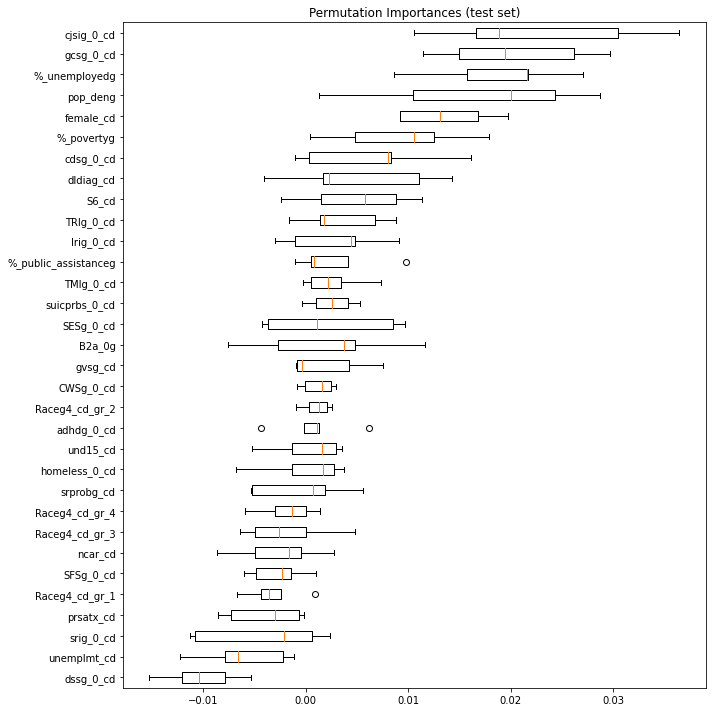

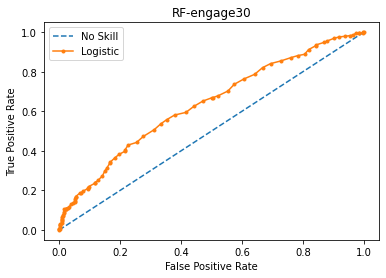

In [178]:
# selected_features = ['female_cd',
#  'nonwhite_cd',
#  'unemplmt_cd',
#  'prsatx_cd',
#  'TRIg_0_cd',
#  'TMIg_0_cd',
#  'SESg_0_cd',
#  'gvsg_cd',
#  'srprobg_cd',
#  'dssg_0_cd',
#  'epsg_0_cd',
#  'adhdg_0_cd',
#  'cdsg_0_cd',
#  'cjsig_0_cd',
#  'lrig_0_cd',
#  'srig_0_cd',
#  'S6_cd',
#  'gcsg_0_cd',
#  'Raceg4_cd_gr_1',
#  'Raceg4_cd_gr_3']
selected_features = list(engage30_X_train.columns)

feat_imp_rf_engage30, perf_stats_rf_engage30 = run_model(RandomForestClassifier(random_state=2017), engage30_X_train[selected_features], engage30_X_test[selected_features], engage30_y_train, engage30_y_test, 'engage30')

Logistic Regression Features: Index(['female_cd', 'unemplmt_cd', 'prsatx_cd', 'und15_cd', 'dldiag_cd',
       'suicprbs_0_cd', 'homeless_0_cd', 'S6_cd', 'ncar_cd', 'Raceg4_cd_gr_1',
       'Raceg4_cd_gr_2', 'Raceg4_cd_gr_3', 'Raceg4_cd_gr_4', 'TRIg_0_cd_0',
       'TRIg_0_cd_2', 'TMIg_0_cd_0', 'TMIg_0_cd_2', 'SESg_0_cd_0',
       'SESg_0_cd_2', 'gvsg_cd_0', 'gvsg_cd_2', 'CWSg_0_cd_0', 'CWSg_0_cd_2',
       'srprobg_cd_0', 'srprobg_cd_2', 'dssg_0_cd_0', 'dssg_0_cd_2',
       'adhdg_0_cd_0', 'adhdg_0_cd_2', 'cdsg_0_cd_0', 'cdsg_0_cd_2',
       'cjsig_0_cd_0', 'cjsig_0_cd_2', 'lrig_0_cd_0', 'lrig_0_cd_2',
       'srig_0_cd_0', 'srig_0_cd_2', 'gcsg_0_cd_0', 'gcsg_0_cd_2',
       'SFSg_0_cd_0', 'SFSg_0_cd_2', 'B2a_0g_0', 'B2a_0g_2', 'pop_deng_0',
       'pop_deng_2', '%_unemployedg_0', '%_unemployedg_2',
       '%_public_assistanceg_0', '%_public_assistanceg_2', '%_povertyg_0',
       '%_povertyg_2'],
      dtype='object')
Logistic Regression Features: Index(['female_cd', 'unemplmt_cd', 'pr

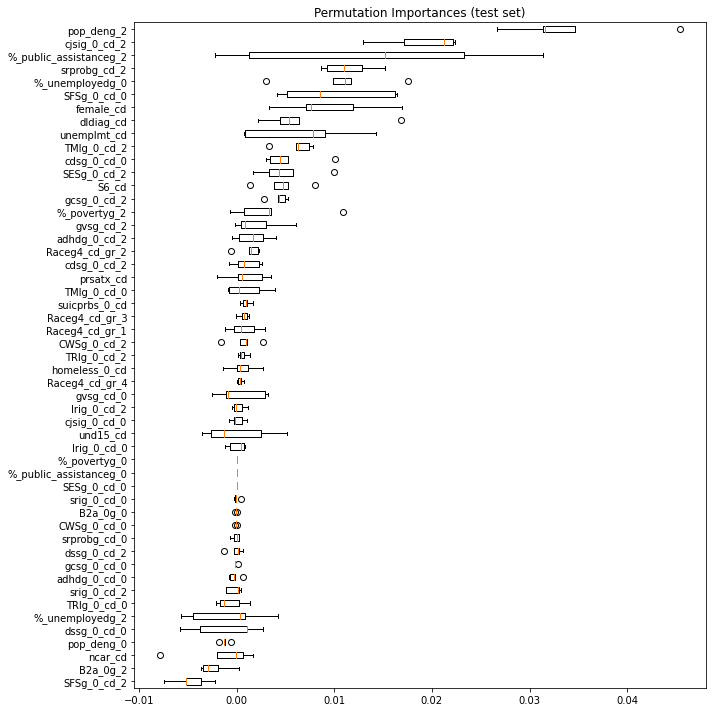

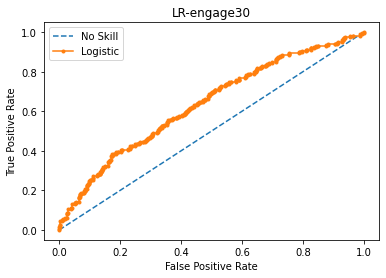

In [179]:
tmp = get_logistic_regression_features(engage30_X_test)
tmp['%_public_assistanceg_0'] = 0
tmp['%_povertyg_0'] = 0

feat_imp_lr_engage30, perf_stats_lr_engage30 = run_model(LogisticRegression(C=0.75, max_iter=1000), get_logistic_regression_features(engage30_X_train), tmp, engage30_y_train, engage30_y_test, 'engage30')

In [180]:
# selected_features = ['female_cd',
#  'unemplmt_cd',
#  'TRIg_0_cd',
#  'TMIg_0_cd',
#  'SESg_0_cd',
#  'gvsg_cd',
#  'srprobg_cd',
#  'dssg_0_cd',
#  'epsg_0_cd',
#  'adhdg_0_cd',
#  'cjsig_0_cd',
#  'S6_cd',
#  'gcsg_0_cd',
#  'SFSg_0_cd',
#  'Raceg4_cd_gr_2',
#  'Raceg4_cd_gr_4']
#selected_features = list(init_X_train.columns)

#feat_imp_rf_init, perf_stats_rf_init = run_model(RandomForestClassifier(random_state=2017), init_X_train[selected_features], init_X_test[selected_features], init_y_train, init_y_test, 'init')

In [181]:
# tmp = get_logistic_regression_features(init_X_test)
# tmp['%_public_assistanceg_0'] = 0
# tmp['%_povertyg_0'] = 0

# feat_imp_lr_init, perf_stats_lr_init = run_model(LogisticRegression(C=0.75, max_iter=1000), get_logistic_regression_features(init_X_train), tmp, init_y_train, init_y_test, 'init')

### Feature Importance Analysis

In [182]:
feat_imp_rf_engage30 = feat_imp_rf_engage30.sort_values(by='RF-engage30', ascending=False)
#feat_imp_rf_init = feat_imp_rf_init.sort_values(by='RF-init', ascending=False)

feat_imp_lr_engage30['mag-from-1'] = abs(feat_imp_lr_engage30['LR-engage30'] - 1)
feat_imp_lr_engage30 = feat_imp_lr_engage30.sort_values(by='mag-from-1', ascending=False)

#feat_imp_lr_init['mag-from-1'] = abs(feat_imp_lr_init['LR-init'] - 1)
#feat_imp_lr_init = feat_imp_lr_init.sort_values(by='LR-init', ascending=False)

In [183]:
display_side_by_side(feat_imp_rf_engage30, 3)

,RF-engage30
feature,
dssg_0_cd,0.046949
cjsig_0_cd,0.046258
gvsg_cd,0.044130
adhdg_0_cd,0.042809
TRIg_0_cd,0.042000
B2a_0g,0.041093
TMIg_0_cd,0.040740
gcsg_0_cd,0.040054
SESg_0_cd,0.039908


In [184]:
display_side_by_side(feat_imp_lr_engage30, 4)

,LR-engage30,mag-from-1
feature,,
%_povertyg_0,1.731702,0.731702
%_public_assistanceg_0,0.412439,0.587561
%_public_assistanceg_2,0.437587,0.562413
SFSg_0_cd_2,1.461345,0.461345
pop_deng_2,0.558328,0.441672
%_unemployedg_0,0.563469,0.436531
%_povertyg_2,1.426107,0.426107
srprobg_cd_2,0.641477,0.358523
SFSg_0_cd_0,1.356950,0.356950


In [185]:
#display_side_by_side(feat_imp_rf_init, 3)

In [186]:
#display_side_by_side(feat_imp_lr_init, 4)

In [187]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(grouping + '_feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feat_imp_rf_engage30.to_excel(writer, sheet_name='RF')
#feat_imp_rf_init.to_excel(writer, sheet_name='RF - init')
feat_imp_lr_engage30.to_excel(writer, sheet_name='LR')
#feat_imp_lr_init.to_excel(writer, sheet_name='LR - init')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Performance Statistics

In [188]:
# relates to performance when we do feature selection
# rf_perf = pd.DataFrame(data=[perf_stats_rf_engage30, perf_stats_rf_init], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
# rf_perf

In [189]:
engage30_perf = pd.DataFrame(data=[perf_stats_rf_engage30, perf_stats_lr_engage30], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
engage30_perf

,model-outcome,true%_1,true%_0,Training Size,Accuracy,F1,Precision,Recall,AUC
0,RF-engage30,0.355769,0.644231,3284,0.453125,0.534289,0.383260,0.881757,0.635904
1,LR-engage30,0.355769,0.644231,3284,0.385817,0.523765,0.361647,0.949324,0.637360


In [190]:
# init_perf = pd.DataFrame(data=[perf_stats_rf_init, perf_stats_lr_init], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
# init_perf

In [191]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 5 seconds ---
